In [1]:
import numpy as np
import timeit
import subprocess

import pandas as pd
import matplotlib.pyplot as plt

## Timing the C++ code

In [2]:
def cpp_pi(n_threads, n_repeats, n_samples):
    result = subprocess.run([
            "../snippets/pi",
            "-j", str(n_threads),
            "-r", str(n_repeats),
            "-s", str(n_samples)],
        capture_output=True)
    return float(result.stdout.decode().split(":")[1])

def time_c_pi(n_threads=1, n_blocks=64, block_size=1e5, repeat=10):
    return timeit.repeat(
        f"cpp_pi({n_threads}, {n_blocks}, {block_size})",
        "from __main__ import cpp_pi",
        repeat=repeat, number=1)

### Paramater choice

In [4]:
threads = np.arange(1, 9)
block_sizes = [int(i) for i in [1e2, 1e3, 1e4, 1e5]]
repeats = 10
work_size = int(16e5)

### Timing

In [4]:
timings = np.array(
    [np.array([np.array(time_c_pi(n, work_size//bs, bs, repeats))
               for n in threads])
     for bs in block_sizes])

In [5]:
from plotnine import (
    ggplot, aes, geom_point, geom_ribbon, scale_x_log10, scale_y_log10, geom_line,
    theme_538, xlab, ylab, themes, facet_wrap, geom_errorbar)

def plot_timings(timings):
    t_median = np.median(timings, axis=2)
    t_min = np.min(timings, axis=2)
    t_max = np.max(timings, axis=2)
    
    summary = pd.DataFrame({
        'threads': np.repeat([threads], len(block_sizes), axis=0).flatten(),
        'block_size': np.repeat(block_sizes, threads.size).astype(int),
        'runtime': t_median.flatten(),
        'min': t_min.flatten(),
        'max': t_max.flatten()})
    
    plot = ggplot(summary, aes('threads', 'runtime', ymin='min', ymax='max', color='factor(block_size)')) \
        + geom_line() + geom_point() + geom_errorbar(width=0.2) \
        + xlab("#threads") + ylab("runtime (s)") + themes.theme_light()

    return plot

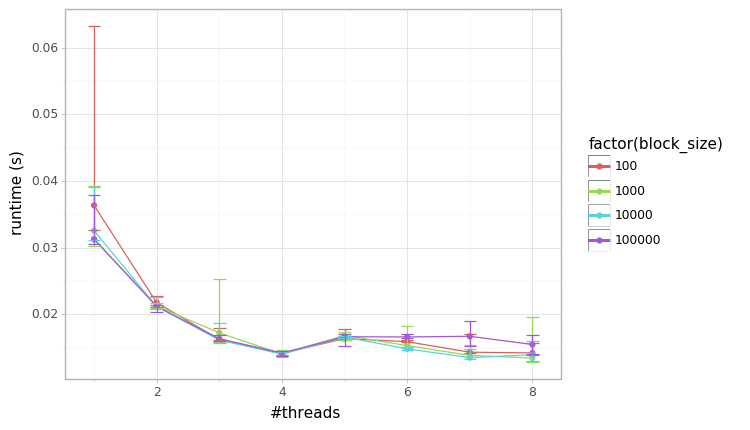

<ggplot: (8770912978045)>

In [6]:
plot_timings(timings)

## Python multiprocessing

In [33]:
import multiprocessing
from itertools import repeat

def compute_pi(N):
    pts = np.random.uniform(0, 1, (2, N))
    M = np.count_nonzero((pts**2).sum(axis=0) < 1)
    return 4 * M / N

def py_pi(n_threads, n_repeats, n_samples):
    pool = multiprocessing.Pool(n_threads)
    result = np.array(pool.map(compute_pi, repeat(n_samples, n_repeats)))
    pool.close()
    pool.join()
    return result.mean()

def time_py_pi(n_threads=1, n_blocks=64, block_size=1e5, repeat=10):
    return timeit.repeat(
        f"py_pi({n_threads}, {n_blocks}, {block_size})",
        "from __main__ import py_pi",
        repeat=repeat, number=1)

In [27]:
%timeit compute_pi(int(16e5))

33.2 ms ± 509 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
timings = np.array(
    [np.array([np.array(time_py_pi(n, work_size//bs, bs, repeats))
               for n in threads])
     for bs in block_sizes])

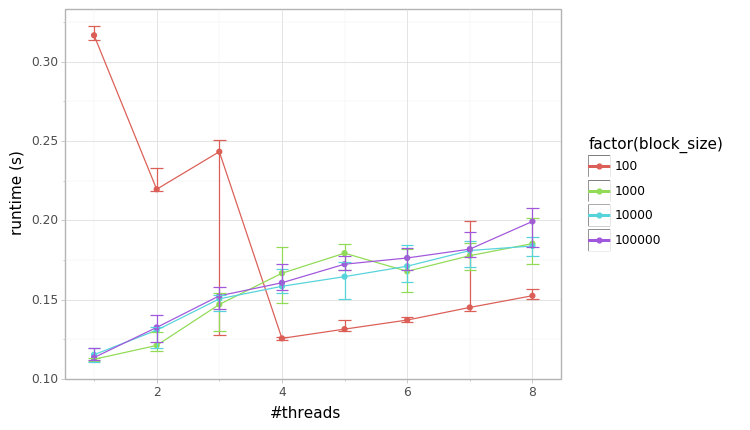

<ggplot: (8770950192613)>

In [35]:
plot_timings(timings)

## Python multi-threading

In [37]:
import threading

def mt_pi(n_threads, n_repeats, n_samples):
    pool = threading.Pool(n_threads)
    result = np.array(pool.map(compute_pi, repeat(n_samples, n_repeats)))
    pool.close()
    pool.join()
    return result.mean()

In [38]:
mt_pi(4, 16, 1e5)

AttributeError: module 'threading' has no attribute 'Pool'